# Partie 2 : Optimisation Multi-Objectif avec NSGA-II
Ce notebook implémente l'optimisation de portefeuille avec contrainte de
cardinalité et coûts de transaction en utilisant l'algorithme génétique NSGA-II.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import plotly.graph_objects as go
import os
import sys
current_dir = os.getcwd()
sys.path.append(os.path.abspath(os.path.join(current_dir, '..', 'py')))
import nsga2_optimizer as nsga2

# 1. Chargmeent des donnés

In [3]:
JOURS_DE_BOURSE = 252

df_rendements = pd.read_csv("../data/returns_final.csv", index_col="Date", parse_dates=True)

mu = df_rendements.mean() * JOURS_DE_BOURSE
Sigma = df_rendements.cov() * JOURS_DE_BOURSE

nombre_actifs = len(mu)
asset_names = mu.index.tolist()

print(f"Nombre d'actifs: {nombre_actifs}")
print(f"Rendement moyen annuel: {mu.mean():.2%}")
print(f"Risque moyen annuel: {np.sqrt(np.diag(Sigma)).mean():.2%}")

Nombre d'actifs: 196
Rendement moyen annuel: 25.00%
Risque moyen annuel: 32.96%


# 2. Configuration de l'Optimisation

In [ ]:
w_current = np.zeros(nombre_actifs)
indices_initiaux = np.random.choice(nombre_actifs, 5, replace=False)
w_current[indices_initiaux] = 0.2


K_CARDINALITE = 10  
COUT_TRANSACTION = 0.005 
POPULATION_SIZE = 100
NB_GENERATIONS = 200

print(f"\n=== Paramètres d'optimisation ===")
print(f"Cardinalité cible (K): {K_CARDINALITE}")
print(f"Coût de transaction: {COUT_TRANSACTION:.2%}")
print(f"Taille de population: {POPULATION_SIZE}")
print(f"Nombre de générations: {NB_GENERATIONS}")


=== Paramètres d'optimisation ===
Cardinalité cible (K): 10
Coût de transaction: 0.50%
Taille de population: 100
Nombre de générations: 200


# 3. Exécution de NSGA-II

In [5]:
print("\nDémarrage de l'optimisation NSGA-II...")
res = nsga2.optimize_portfolio_nsga2(
    mu=mu,
    Sigma=Sigma,
    w_current=w_current,
    K=K_CARDINALITE,
    pop_size=POPULATION_SIZE,
    n_gen=NB_GENERATIONS,
    c_prop=COUT_TRANSACTION,
    verbose=True
)

print("\nOptimisation terminée!")


Démarrage de l'optimisation NSGA-II...
n_gen  |  n_eval  | n_nds  |     cv_min    |     cv_avg    |      eps      |   indicator  
     1 |      100 |     23 |  0.000000E+00 |  0.0050000000 |             - |             -
     2 |      200 |     23 |  0.000000E+00 |  0.0050000000 |  0.000000E+00 |             f
     3 |      300 |     23 |  0.000000E+00 |  0.0004514121 |  0.000000E+00 |             f
     4 |      400 |     23 |  0.000000E+00 |  0.0004514121 |  0.000000E+00 |             f
     5 |      500 |     23 |  0.000000E+00 |  0.0004514121 |  0.000000E+00 |             f
     6 |      600 |     23 |  0.000000E+00 |  0.0004514121 |  0.000000E+00 |             f
     7 |      700 |     23 |  0.000000E+00 |  0.0004514121 |  0.000000E+00 |             f
     8 |      800 |     23 |  0.000000E+00 |  0.0004514121 |  0.000000E+00 |             f
     9 |      900 |     23 |  0.000000E+00 |  0.0004514121 |  0.000000E+00 |             f
    10 |     1000 |     23 |  0.000000E+00 |  0.00

# 4. Analyse des Résultats

In [6]:
stats = nsga2.get_portfolio_statistics(res)

print("\n=== Statistiques du Front de Pareto ===")
print(f"Nombre de solutions Pareto-optimales: {stats['n_solutions']}")
print(f"\nRendement:")
print(f"  Min: {stats['return_min']:.2%}")
print(f"  Max: {stats['return_max']:.2%}")
print(f"  Moyen: {stats['return_mean']:.2%}")
print(f"\nRisque (Volatilité):")
print(f"  Min: {stats['risk_min']:.2%}")
print(f"  Max: {stats['risk_max']:.2%}")
print(f"  Moyen: {stats['risk_mean']:.2%}")
print(f"\nCoûts de Transaction:")
print(f"  Min: {stats['cost_min']:.2%}")
print(f"  Max: {stats['cost_max']:.2%}")
print(f"  Moyen: {stats['cost_mean']:.2%}")


=== Statistiques du Front de Pareto ===
Nombre de solutions Pareto-optimales: 23

Rendement:
  Min: 9.52%
  Max: 44.08%
  Moyen: 26.70%

Risque (Volatilité):
  Min: 14.93%
  Max: 29.31%
  Moyen: 21.39%

Coûts de Transaction:
  Min: 0.62%
  Max: 1.00%
  Moyen: 0.90%


# 5. Visualisation du Front de Pareto 3D

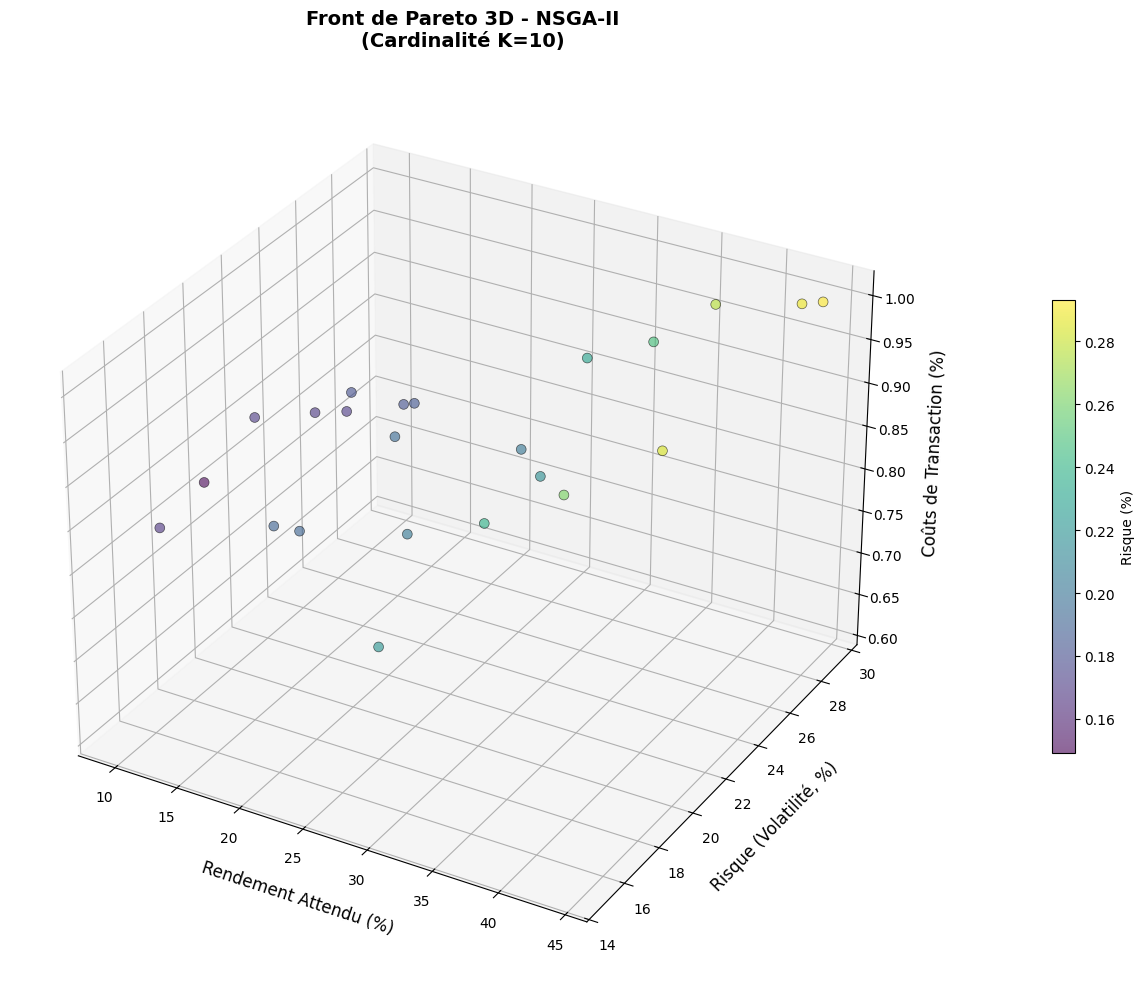

In [ ]:
F = res.F
returns = -F[:, 0]
risks = np.sqrt(F[:, 1])
costs = F[:, 2]

fig = plt.figure(figsize=(14, 10))
ax = fig.add_subplot(111, projection='3d')

scatter = ax.scatter(
    returns * 100,
    risks * 100,
    costs * 100,
    c=risks,
    cmap='viridis',
    s=50,
    alpha=0.6,
    edgecolors='black',
    linewidth=0.5
)

ax.set_xlabel('Rendement Attendu (%)', fontsize=12, labelpad=10)
ax.set_ylabel('Risque (Volatilité, %)', fontsize=12, labelpad=10)
ax.set_zlabel('Coûts de Transaction (%)', fontsize=12, labelpad=10)
ax.set_title(f'Front de Pareto 3D - NSGA-II\n(Cardinalité K={K_CARDINALITE})',
             fontsize=14, fontweight='bold', pad=20)

plt.colorbar(scatter, label='Risque (%)', shrink=0.5, pad=0.1)
plt.tight_layout()
plt.show()

fig_plotly = go.Figure(data=[go.Scatter3d(
    x=returns * 100,
    y=risks * 100,
    z=costs * 100,
    mode='markers',
    marker=dict(
        size=5,
        color=risks * 100,
        colorscale='Viridis',
        showscale=True,
        colorbar=dict(title="Risque (%)"),
        opacity=0.8
    ),
    text=[f'R: {r:.2%}<br>V: {v:.2%}<br>C: {c:.2%}'
          for r, v, c in zip(returns, risks, costs)],
    hoverinfo='text'
)])

fig_plotly.update_layout(
    title=f'Front de Pareto 3D Interactif (K={K_CARDINALITE})',
    scene=dict(
        xaxis_title='Rendement (%)',
        yaxis_title='Risque (%)',
        zaxis_title='Coûts (%)'
    ),
    width=900,
    height=700
)

fig_plotly.show()

# 6. Sélection d'un Portefeuille Optimal

In [ ]:
R_MIN = 0.15 

print(f"\n=== Sélection du Portefeuille Optimal ===")
print(f"Contrainte: Rendement >= {R_MIN:.2%}")

X_s1, F_s1 = nsga2.filter_step1_return(res, R_MIN)

if X_s1 is not None:
    # 2. Filtrage par Risque (Keep 'Safe' candidates within 5% tolerance)
    # Cela permet à l'étape suivante d'avoir le choix entre plusieurs portefeuilles peu risqués
    X_s2, F_s2 = nsga2.filter_step2_risk(X_s1, F_s1, tolerance=0.05)

    if X_s2 is not None:
        # 3. Sélection par Coût (Pick Cheapest)
        best_weights, best_return, best_risk, best_cost = nsga2.select_step3_cost(
            X_s2, F_s2
        )

        print("=== RÉSULTAT OPTIMAL (Entonnoir Rendement -> Risque -> Coût) ===")
        print(f"Rendement : {best_return:.2%}")
        print(f"Risque    : {best_risk:.2%}")
        print(f"Coût      : {best_cost:.2%}")
    else:
        print("Erreur : Le filtre de risque a éliminé toutes les solutions.")
else:
    print("Erreur : Rendement inatteignable.")


=== Sélection du Portefeuille Optimal ===
Contrainte: Rendement >= 15.00%

✅ Portefeuille sélectionné:
  Rendement: 16.32%
  Risque: 14.93%
  Coûts: 0.93%
  Ratio de Sharpe: 1.09

📊 Top 10 des Actifs:
  GIS: 25.96%
  KR: 19.65%
  ROP: 19.27%
  BK: 13.50%
  PEP: 7.32%
  CAT: 5.67%
  WMT: 4.50%
  COST: 2.97%
  ORCL: 0.64%
  EL: 0.51%

📈 Nombre d'actifs dans le portefeuille: 10


# 7. Projections 2D du Front de Pareto

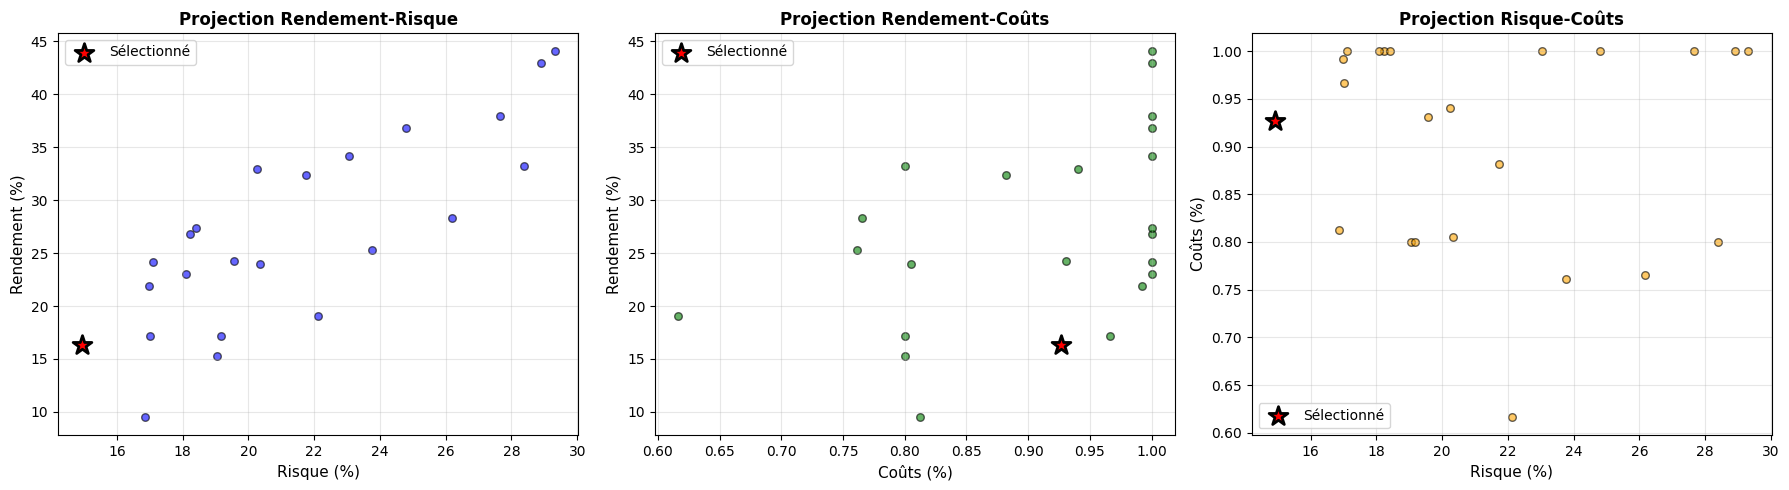

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

axes[0].scatter(risks * 100, returns * 100, alpha=0.6, s=30, c='blue', edgecolors='black')
if X_s1 is not None:
    axes[0].scatter(best_risk * 100, best_return * 100,
                   color='red', s=200, marker='*',
                   edgecolors='black', linewidth=2, label='Sélectionné')
axes[0].set_xlabel('Risque (%)', fontsize=11)
axes[0].set_ylabel('Rendement (%)', fontsize=11)
axes[0].set_title('Projection Rendement-Risque', fontsize=12, fontweight='bold')
axes[0].grid(True, alpha=0.3)
axes[0].legend()

axes[1].scatter(costs * 100, returns * 100, alpha=0.6, s=30, c='green', edgecolors='black')
if X_s1 is not None:
    axes[1].scatter(best_cost * 100, best_return * 100,
                   color='red', s=200, marker='*',
                   edgecolors='black', linewidth=2, label='Sélectionné')
axes[1].set_xlabel('Coûts (%)', fontsize=11)
axes[1].set_ylabel('Rendement (%)', fontsize=11)
axes[1].set_title('Projection Rendement-Coûts', fontsize=12, fontweight='bold')
axes[1].grid(True, alpha=0.3)
axes[1].legend()

axes[2].scatter(risks * 100, costs * 100, alpha=0.6, s=30, c='orange', edgecolors='black')
if X_s1 is not None:
    axes[2].scatter(best_risk * 100, best_cost * 100,
                   color='red', s=200, marker='*',
                   edgecolors='black', linewidth=2, label='Sélectionné')
axes[2].set_xlabel('Risque (%)', fontsize=11)
axes[2].set_ylabel('Coûts (%)', fontsize=11)
axes[2].set_title('Projection Risque-Coûts', fontsize=12, fontweight='bold')
axes[2].grid(True, alpha=0.3)
axes[2].legend()

plt.tight_layout()
plt.show()

# 8. Sauvegarde des Résultats

In [ ]:
df_pareto = pd.DataFrame({
    'Rendement': returns,
    'Risque': risks,
    'Couts': costs
})

output_dir = "../results" if os.path.exists("../results") else "results"
os.makedirs(output_dir, exist_ok=True)

df_pareto.to_csv(f"{output_dir}/pareto_front_nsga2.csv", index=False)
print(f"\nFront de Pareto sauvegardé dans '{output_dir}/pareto_front_nsga2.csv'")

if X_s1 is not None:
    df_optimal = pd.DataFrame({
        'Asset': asset_names,
        'Weight': best_weights
    })
    df_optimal = df_optimal[df_optimal['Weight'] > 1e-4].sort_values('Weight', ascending=False)
    df_optimal.to_csv(f"{output_dir}/optimal_portfolio_nsga2.csv", index=False)
    print(f"Portefeuille optimal sauvegardé dans '{output_dir}/optimal_portfolio_nsga2.csv'")

print("\nAnalyse complète terminée!")


💾 Front de Pareto sauvegardé dans 'results/pareto_front_nsga2.csv'
💾 Portefeuille optimal sauvegardé dans 'results/optimal_portfolio_nsga2.csv'

✅ Analyse complète terminée!
